# Compare USDM & SPI
a. stein 4.27.2022

Building off of `explore/usdm_spi_explore_workflow.ipynb`, this notebook builds upon lessons learned and the workflow developed there to more thoroughly compare the USDM and various interval SPIs.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


Load in data

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

# USDM & SPI already clipped in WA folders
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [3]:
spi = xr.open_dataset(f'{dm_path}/spi/WA/spi_usdmcat_WA.nc')

In [4]:
#spi_1y = xr.open_dataset(f'{dm_path}/spi/WA/spi_1y.nc')
#spi_2y = xr.open_dataset(f'{dm_path}/spi/WA/spi_2y.nc')
#spi_5y = xr.open_dataset(f'{dm_path}/spi/WA/spi_5y.nc')
#spi_14d = xr.open_dataset(f'{dm_path}/spi/WA/spi_14d.nc')
#spi_30d = xr.open_dataset(f'{dm_path}/spi/WA/spi_30d.nc')
#spi_90d = xr.open_dataset(f'{dm_path}/spi/WA/spi_90d.nc')
#spi_180d = xr.open_dataset(f'{dm_path}/spi/WA/spi_180d.nc')
#spi_270d = xr.open_dataset(f'{dm_path}/spi/WA/spi_270d.nc')

In [5]:
#spi_list = [spi_1y, spi_2y, spi_5y, spi_14d, spi_30d, spi_90d, spi_180d, spi_270d]

In [6]:
spi_intervals = ['1y', '2y', '5y', '14d', '30d', '90d', '180d', '270d']

In [7]:
spi_da_list = [spi[f'spi_{interval}'] for interval in spi_intervals]

Check if SPI dates and coordinates all match

In [8]:
#for spi in spi_list[1:]:
#    if len(np.where(spi_1y['day'].values != spi['day'].values)[0]) != 0:
#        print('Time mistmatch')
#    if len(np.where(spi_1y['lat'].values != spi['lat'].values)[0]) != 0:
#        print('lat mismatch')
#    if len(np.where(spi_1y['lon'].values != spi['lon'].values)[0]) != 0:
#        print('lon mismatch')

Cool, so then I only need to make 1 set of paired dates and upscale USDM to 1 of the SPI grids cause they're all the same.

In [9]:
usdm_da = usdm['USDM'].rio.write_crs('EPSG:4326', inplace=True)
#spi_1y_da = spi_1y['spi'].rio.write_crs('EPSG:4326', inplace=True)
#usdm_upscale = (usdm_da).rio.reproject_match(spi_1y_da)

spi_da = [spi.rio.write_crs('EPSG:4326', inplace=True) for spi in spi_da_list]
usdm_upscale = usdm_da.rio.reproject_match(spi_da[0])

In [11]:
usdm_dates = pd.DatetimeIndex(usdm['date'].values)
#usdm_dates = usdm_dates[usdm_dates < '2022']

spi_dates = pd.DatetimeIndex(spi_da[0]['day'].values)
#spi_dates = spi_dates[spi_dates >= '1999-12-31']

pair_dates = compare.pair_to_usdm_date(usdm_dates, spi_dates, 'SPI Date', realign=True)
pair_dates

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
../../ndrought/compare.py:119: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  pair_dates = pair_dates.dropna('index')


,SPI Date,USDM Date
0,1999-12-31,2000-01-04 00:00:00
1,2000-01-10,2000-01-11 00:00:00
2,2000-01-15,2000-01-18 00:00:00
3,2000-01-25,2000-01-25 00:00:00
4,2000-01-30,2000-02-01 00:00:00
...,...,...
1143,2021-11-26,2021-11-30 00:00:00
1144,2021-12-06,2021-12-07 00:00:00
1145,2021-12-11,2021-12-14 00:00:00
1146,2021-12-21,2021-12-21 00:00:00


Add in Hydrologic Year (need to double check I have the counting right ...)

In [12]:
pair_dates['USDM Hydrologic Year'] = (pd.DatetimeIndex(pair_dates['USDM Date']) + pd.DateOffset(months=3)).year
pair_dates

,SPI Date,USDM Date,USDM Hydrologic Year
0,1999-12-31,2000-01-04 00:00:00,2000
1,2000-01-10,2000-01-11 00:00:00,2000
2,2000-01-15,2000-01-18 00:00:00,2000
3,2000-01-25,2000-01-25 00:00:00,2000
4,2000-01-30,2000-02-01 00:00:00,2000
...,...,...,...
1143,2021-11-26,2021-11-30 00:00:00,2022
1144,2021-12-06,2021-12-07 00:00:00,2022
1145,2021-12-11,2021-12-14 00:00:00,2022
1146,2021-12-21,2021-12-21 00:00:00,2022


Convert SPI to USDM categories ... (already did this with the saved out file)

In [7]:
#spi_usdmcat = dict()

#for spi, interval in tqdm(zip(spi_list, spi_intervals), total=len(spi_intervals)):
#    spi_usdmcat[interval] = compare.spi_to_usdmcat_multtime(spi['spi'].sel(day=pair_dates['SPI Date'].values))

  0%|          | 0/8 [00:00<?, ?it/s]

This looks like it might take a bit ... should save out this dataset once done ... (which we did)

In [13]:
#spi_usdmcat_ds = spi_usdmcat[spi_intervals[0]].copy().to_dataset(name=f'spi_{spi_intervals[0]}')
#del spi_usdmcat_ds[f'spi_{spi_intervals[0]}'].attrs['grid_mapping']
#spi_usdmcat_ds

In [14]:
#for interval in spi_intervals[1:]:
#    spi_usdmcat_ds[f'spi_{interval}'] = spi_usdmcat[interval]
#    del spi_usdmcat_ds[f'spi_{interval}'].attrs['grid_mapping']

In [16]:
#spi_usdmcat_ds.attrs = {
#    'author' : 'a. stein, 4/28/2022',
#    'description' : 'Standardized Precipitation Index (SPI) gathered from various time windows, (specified by the value following the underscore), categorized into USDM categories ndrought.compare.spi_to_usdmcat function.',
#    'clipping' : 'Clipped to Washington state using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#}
#spi_usdmcat_ds

In [17]:
#spi_usdmcat_ds.to_netcdf(f'{dm_path}/spi/WA/spi_usdmcat_WA.nc')

Wonderful. Now we can skip the above section for quicker loading (cutting down like 15 minutes of clipping)

Now I need to make an all encompassing dataset that is not based on time as a coordinate but uses the index from `pair_dates`

In [67]:
timeless_ds = usdm_upscale.sel(date=pair_dates['USDM Date'].values).to_dataset()
timeless_ds['date'] = pair_dates.index.values
timeless_ds = timeless_ds.rename_dims({'date':'index', 'x':'lon', 'y':'lat'})
timeless_ds = timeless_ds.rename_vars({'date':'index', 'x':'lon', 'y':'lat'})
timeless_ds['USDM Date'] = xr.DataArray(
    pair_dates['USDM Date'].values, 
    dims=['index'], 
    coords=dict(index=pair_dates.index.values)
)
timeless_ds

<xarray.Dataset>
Dimensions:      (index: 1148, lon: 188, lat: 84)
Coordinates:
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
    spatial_ref  int64 0
Data variables:
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28

In [68]:
for spi, interval in zip(spi_da, spi_intervals):
    timeless_ds[f'spi_{interval}'] = xr.DataArray(
        spi.values,
        dims=['index', 'lat', 'lon'],
        coords=dict(
            index=timeless_ds['index'].values,
            lat = spi['lat'].values,
            lon = spi['lon'].values,
        )
    )

In [70]:
timeless_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
    spatial_ref  int64 0
Data variables:
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_2y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_5y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_14d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_30d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_90d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_180d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_270d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [71]:
timeless_ds['SPI Date'] = xr.DataArray(
    pair_dates['SPI Date'].values, 
    dims=['index'], 
    coords=dict(index=pair_dates.index.values)
)
timeless_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
    spatial_ref  int64 0
Data variables:
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_2y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_5y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_14d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_30d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_90d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_180d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_270d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SPI Date     (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26

Alrighty, that is looking pretty good.

Make some preliminary plots

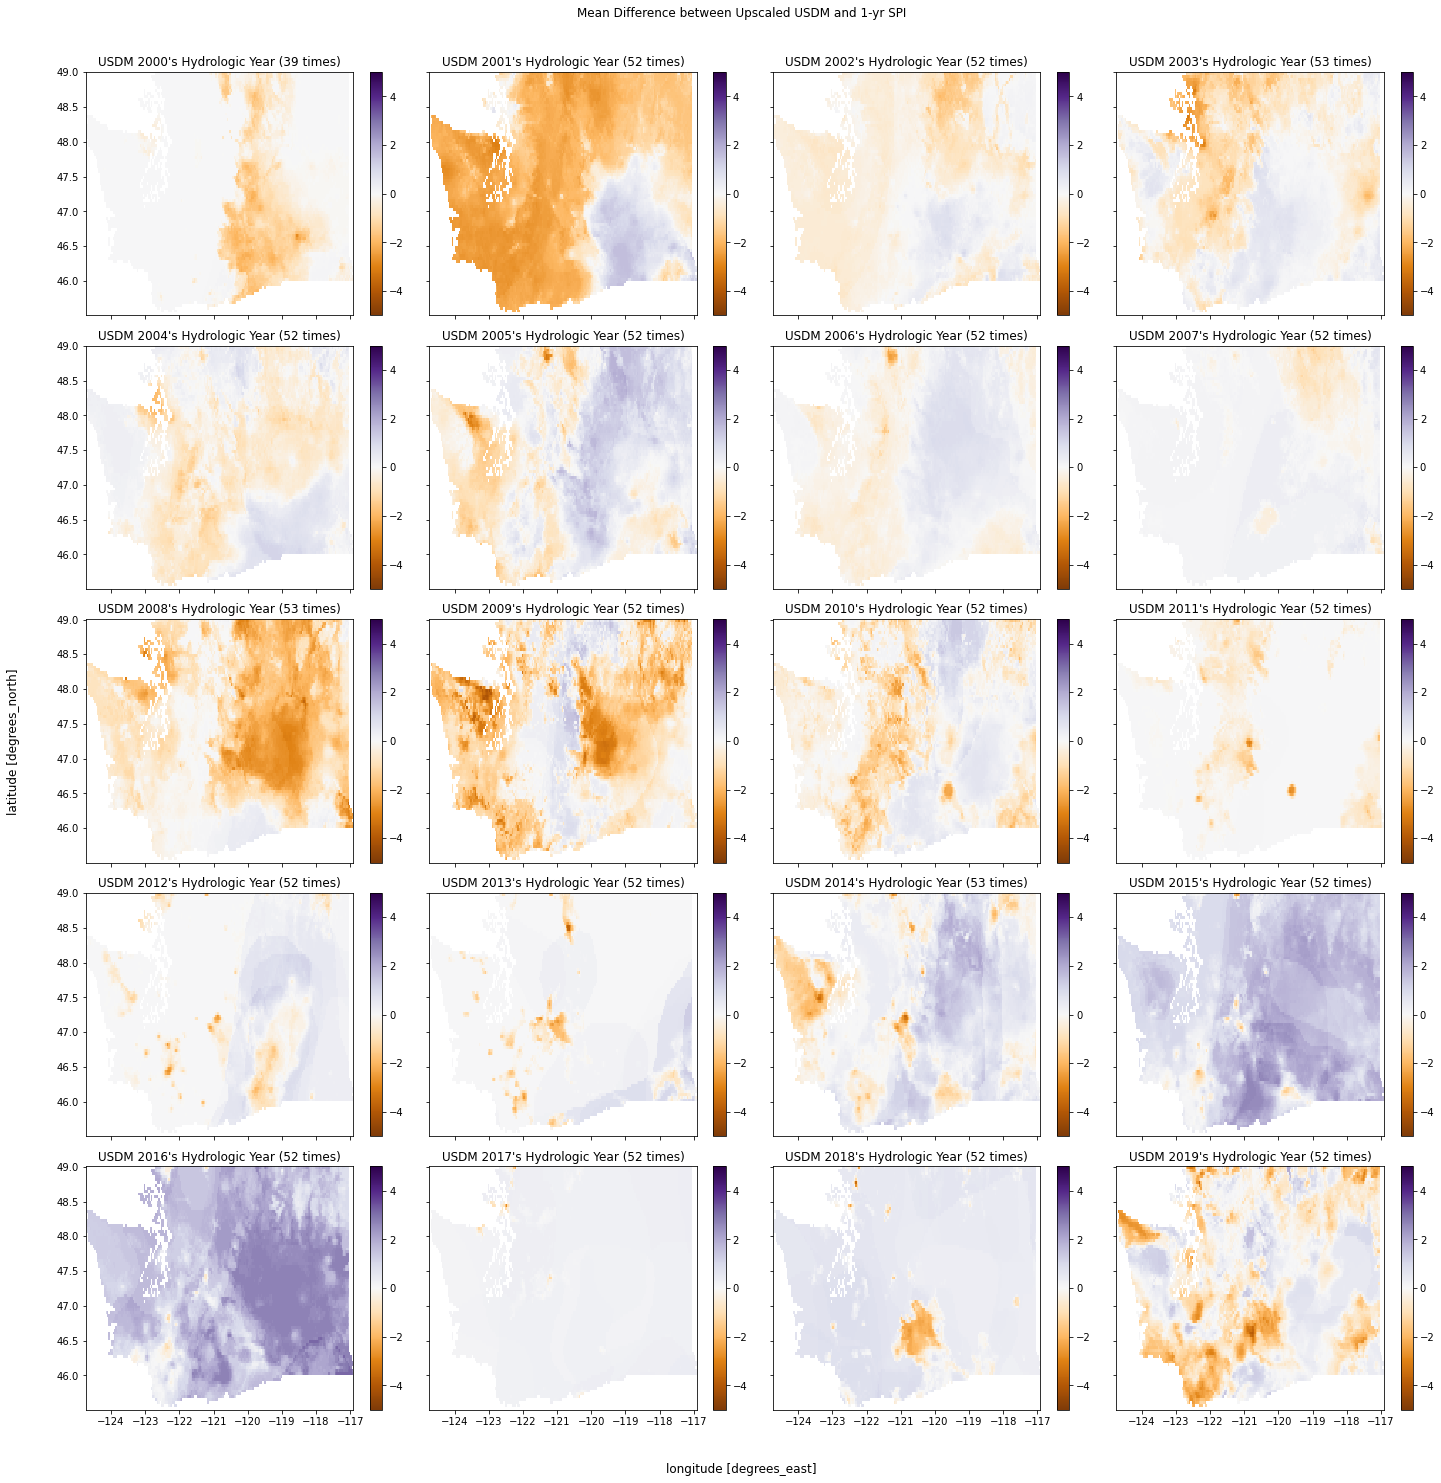

In [73]:
fig, axs = plt.subplots(5,4, figsize=(20, 20), sharex=True, sharey=True)

for year, ax in zip(np.arange(2000, 2021, 1), axs.ravel()):
    hyear_idxs = pair_dates[pair_dates['USDM Hydrologic Year'] == pd.to_datetime(f'{year}').year].index.values
    extreme = 5*len(hyear_idxs)
    (timeless_ds['USDM'].sel(index=hyear_idxs)-timeless_ds['spi_1y'].sel(index=hyear_idxs)).mean(dim='index').plot(ax=ax, vmin=-5, vmax=5, cmap='PuOr')

    ax.set_title(f"USDM {year}'s Hydrologic Year ({len(hyear_idxs)} times)")
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.supylabel('latitude [degrees_north]', x=-0.01)
fig.supxlabel('longitude [degrees_east]', y=-0.01)
fig.suptitle('Mean Difference between Upscaled USDM and 1-yr SPI', y=1.01)

plt.tight_layout()